In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import random

import soundfile as sf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

In [3]:
CWD = Path().resolve()
PROJECT_ROOT = CWD.parents[1]
OUT_ROOT = PROJECT_ROOT / "data" / "processed" / "hls_cmds"

CSV_HS  = OUT_ROOT / "hs_segments.csv"
CSV_LS  = OUT_ROOT / "ls_segments.csv"
CSV_MIX = OUT_ROOT / "mix_segments.csv"

assert CSV_HS.exists(), CSV_HS
assert CSV_LS.exists(), CSV_LS
assert CSV_MIX.exists(), CSV_MIX

OUT_ROOT


WindowsPath('C:/Users/MSI/Documents/Persoonlijke Projecten/AI-Onderzoeksvragen/research_questions/heart_and_lungsounds/data/processed/hls_cmds')

In [4]:
def load_split_csv(csv_path: Path, kind: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df["label"] = kind
    return df

df_hs  = load_split_csv(CSV_HS,  "hs")
df_ls  = load_split_csv(CSV_LS,  "ls")
df_mix = load_split_csv(CSV_MIX, "mix")

df = pd.concat([df_hs, df_ls, df_mix], ignore_index=True)

df.shape, df.columns.tolist()


((3185, 13),
 ['category',
  'location',
  'gender',
  'file_name',
  'wav_path',
  'heart_label',
  'lung_label',
  'mix_label',
  'segment_index',
  'seg_start_sec',
  'seg_end_sec',
  'audio_path',
  'label'])

In [5]:
def resolve_audio_path(row, out_root: Path) -> Path | None:
    ap = row.get("audio_path", None)
    if ap is None or (isinstance(ap, float) and np.isnan(ap)):
        return None
    p = Path(str(ap))
    if p.is_absolute():
        return p
    return (PROJECT_ROOT / p).resolve()

df["audio_path_resolved"] = df.apply(lambda r: resolve_audio_path(r, OUT_ROOT), axis=1)
df["audio_exists"] = df["audio_path_resolved"].apply(lambda p: (p is not None) and Path(p).exists())

missing = (~df["audio_exists"]).sum()
print("Rows:", len(df), "| Missing audio:", int(missing))
assert missing == 0, "There are unresolved audio paths (check your prep outputs / relative paths)."


Rows: 3185 | Missing audio: 0


In [6]:
LABELS = ["hs", "ls", "mix"]
label2id = {l: i for i, l in enumerate(LABELS)}
id2label = {i: l for l, i in label2id.items()}

df["label"] = df["label"].astype(str).str.strip().str.lower()
bad = set(df["label"].unique()) - set(LABELS)
assert not bad, f"Unexpected labels: {sorted(bad)}"

df["y"] = df["label"].map(label2id).astype(int)

df["label"].value_counts()


label
mix    1885
hs      650
ls      650
Name: count, dtype: int64

In [7]:
def pick_group_col(df: pd.DataFrame) -> str:
    for c in ["file_name", "wav_path", "record_id", "mixed_sound_id", "heart_sound_id", "lung_sound_id"]:
        if c in df.columns:
            return c
    return "index_fallback"

GROUP_COL = pick_group_col(df)
if GROUP_COL == "index_fallback":
    df["index_fallback"] = np.arange(len(df))
GROUP_COL


'file_name'

In [8]:
def split_by_group(df: pd.DataFrame, group_col: str, seed=42):
    gss1 = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=seed)
    train_idx, test_idx = next(gss1.split(df, groups=df[group_col]))

    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_test  = df.iloc[test_idx].reset_index(drop=True)

    gss2 = GroupShuffleSplit(n_splits=1, test_size=0.1765, random_state=seed)  # 0.1765 of 0.85 ≈ 0.15
    tr_idx, val_idx = next(gss2.split(df_train, groups=df_train[group_col]))

    df_tr  = df_train.iloc[tr_idx].reset_index(drop=True)
    df_val = df_train.iloc[val_idx].reset_index(drop=True)

    return df_tr, df_val, df_test

df_train, df_val, df_test = split_by_group(df, GROUP_COL, seed=SEED)

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))
print("Group leakage check:",
      len(set(df_train[GROUP_COL]) & set(df_val[GROUP_COL])) == 0,
      len(set(df_train[GROUP_COL]) & set(df_test[GROUP_COL])) == 0,
      len(set(df_val[GROUP_COL]) & set(df_test[GROUP_COL])) == 0)


Train: 2223 Val: 481 Test: 481
Group leakage check: True True True


In [9]:
def class_weights_from_df(df_train: pd.DataFrame, n_classes: int) -> torch.Tensor:
    counts = df_train["y"].value_counts().reindex(range(n_classes), fill_value=0).values.astype(np.float32)
    w = counts.sum() / np.maximum(counts, 1.0)
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32)

class_weights_from_df(df_train, len(LABELS))


tensor([1.2124, 1.3639, 0.4237])

In [10]:
def stft_power_db(y, sr, n_fft=256, hop=64):
    y_t = torch.tensor(y, dtype=torch.float32)
    win = torch.hann_window(n_fft)
    spec = torch.stft(y_t, n_fft=n_fft, hop_length=hop, win_length=n_fft, window=win, return_complex=True)
    power = (spec.real**2 + spec.imag**2)
    power = torch.clamp(power, min=1e-10)
    db = 10.0 * torch.log10(power)
    return db.numpy()

def mel_filterbank(sr, n_fft, n_mels, fmin, fmax):
    import librosa
    return librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels, fmin=fmin, fmax=fmax)

def logmel_db(y, sr, n_fft=256, hop=64, n_mels=64, fmin=20.0, fmax=None):
    import librosa
    if fmax is None:
        fmax = sr / 2
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=n_fft, window="hann"))**2
    M = mel_filterbank(sr, n_fft, n_mels, fmin, fmax).dot(S)
    M = np.maximum(M, 1e-10)
    db = 10.0 * np.log10(M)
    return db

def minmax_01(x):
    x = x.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    if mx - mn < 1e-8:
        return np.zeros_like(x, dtype=np.float32)
    return (x - mn) / (mx - mn)


In [11]:
CACHE_ROOT = OUT_ROOT / "features_cache"
CACHE_ROOT.mkdir(parents=True, exist_ok=True)

def cache_path(feature_type: str, key: str) -> Path:
    d = CACHE_ROOT / feature_type
    d.mkdir(parents=True, exist_ok=True)
    return d / f"{key}.npy"

def make_cache_key(row) -> str:
    fn = str(row.get("file_name", "nofile")).replace(os.sep, "_")
    si = int(row.get("segment_index", 0)) if "segment_index" in row else 0
    return f"{fn}__seg{si:06d}"

def extract_feature_for_row(row, feature_type: str):
    p = Path(row["audio_path_resolved"])
    y, sr = sf.read(str(p), dtype="float32")
    if y.ndim > 1:
        y = np.mean(y, axis=1)

    if feature_type == "logmel":
        feat = logmel_db(y, sr, n_fft=256, hop=64, n_mels=64, fmin=20.0, fmax=sr/2)
    elif feature_type == "stft":
        feat = stft_power_db(y, sr, n_fft=256, hop=64)
    else:
        raise ValueError(feature_type)

    feat = minmax_01(feat)
    feat = feat.astype(np.float32)
    return feat

def extract_and_cache_row(row, feature_type: str) -> str:
    key = make_cache_key(row)
    cp = cache_path(feature_type, key)
    if not cp.exists():
        feat = extract_feature_for_row(row, feature_type)
        np.save(cp, feat)
    return str(cp)


In [12]:
class CachedFeatureDataset(Dataset):
    def __init__(self, df_split: pd.DataFrame, feature_type: str):
        self.df = df_split.reset_index(drop=True)
        self.feature_type = feature_type
        self.cache_files = []

        for _, row in self.df.iterrows():
            cp = cache_path(feature_type, make_cache_key(row))
            if not cp.exists():
                _ = extract_and_cache_row(row, feature_type)
            self.cache_files.append(str(cp))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.load(self.cache_files[idx]).astype(np.float32)  # (F, T)
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # (1, F, T)
        y = int(self.df.loc[idx, "y"])
        return x, y


In [13]:
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.head = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.head(x)


In [14]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ys, ps = [], []
    total_loss = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        logits = model(xb)
        loss = nn.functional.cross_entropy(logits, yb)
        total_loss += float(loss.item()) * len(yb)
        n += len(yb)
        pred = torch.argmax(logits, dim=1)
        ys.append(yb.cpu().numpy())
        ps.append(pred.cpu().numpy())
    ys = np.concatenate(ys) if ys else np.array([])
    ps = np.concatenate(ps) if ps else np.array([])
    acc = float((ys == ps).mean()) if len(ys) else 0.0
    return total_loss / max(n, 1), acc, ys, ps


In [15]:
def train_one_run(feature_type="logmel", use_weights=True, epochs=15, batch_size=64, lr=1e-3):
    run_dir = OUT_ROOT / "baseline_runs" / f"{feature_type}__weights_{int(use_weights)}"
    run_dir.mkdir(parents=True, exist_ok=True)

    ds_tr  = CachedFeatureDataset(df_train, feature_type)
    ds_val = CachedFeatureDataset(df_val, feature_type)
    ds_te  = CachedFeatureDataset(df_test, feature_type)

    dl_tr  = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=0)
    dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=0)
    dl_te  = DataLoader(ds_te, batch_size=batch_size, shuffle=False, num_workers=0)

    model = SmallCNN(n_classes=len(LABELS)).to(DEVICE)

    if use_weights:
        w = class_weights_from_df(df_train, len(LABELS)).to(DEVICE)
        criterion = nn.CrossEntropyLoss(weight=w)
    else:
        criterion = nn.CrossEntropyLoss()

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    best_val_loss = float("inf")
    best_path = run_dir / "best.pt"

    for ep in range(1, epochs + 1):
        model.train()
        tr_loss = 0.0
        tr_n = 0
        tr_correct = 0

        for xb, yb in dl_tr:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optim.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optim.step()

            tr_loss += float(loss.item()) * len(yb)
            tr_n += len(yb)
            tr_correct += int((torch.argmax(logits, dim=1) == yb).sum().item())

        train_loss = tr_loss / max(tr_n, 1)
        train_acc = tr_correct / max(tr_n, 1)

        val_loss, val_acc, _, _ = evaluate(model, dl_val)

        history.append({
            "epoch": ep,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc
        })

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

    pd.DataFrame(history).to_csv(run_dir / "history.csv", index=False)

    model.load_state_dict(torch.load(best_path, map_location=DEVICE))

    test_loss, test_acc, y_true, y_pred = evaluate(model, dl_te)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABELS))))
    np.save(run_dir / "confusion_matrix.npy", cm)

    rep = classification_report(
        y_true,
        y_pred,
        target_names=[l.upper() for l in LABELS],
        output_dict=True,
        zero_division=0
    )
    pd.DataFrame(rep).T.to_csv(run_dir / "test_classification_report.csv")

    with open(run_dir / "test_summary.txt", "w", encoding="utf-8") as f:
        f.write(f"feature_type: {feature_type}\n")
        f.write(f"use_weights: {use_weights}\n")
        f.write(f"test_loss: {test_loss:.6f}\n")
        f.write(f"test_acc: {test_acc:.6f}\n")

    return str(run_dir)

run_dir = train_one_run(feature_type="logmel", use_weights=True, epochs=15)
run_dir


C:\Users\MSI\AppData\Local\Temp\ipykernel_175244\938343573.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=DEVI

'C:\\Users\\MSI\\Documents\\Persoonlijke Projecten\\AI-Onderzoeksvragen\\research_questions\\heart_and_lungsounds\\data\\processed\\hls_cmds\\baseline_runs\\logmel__weights_1'

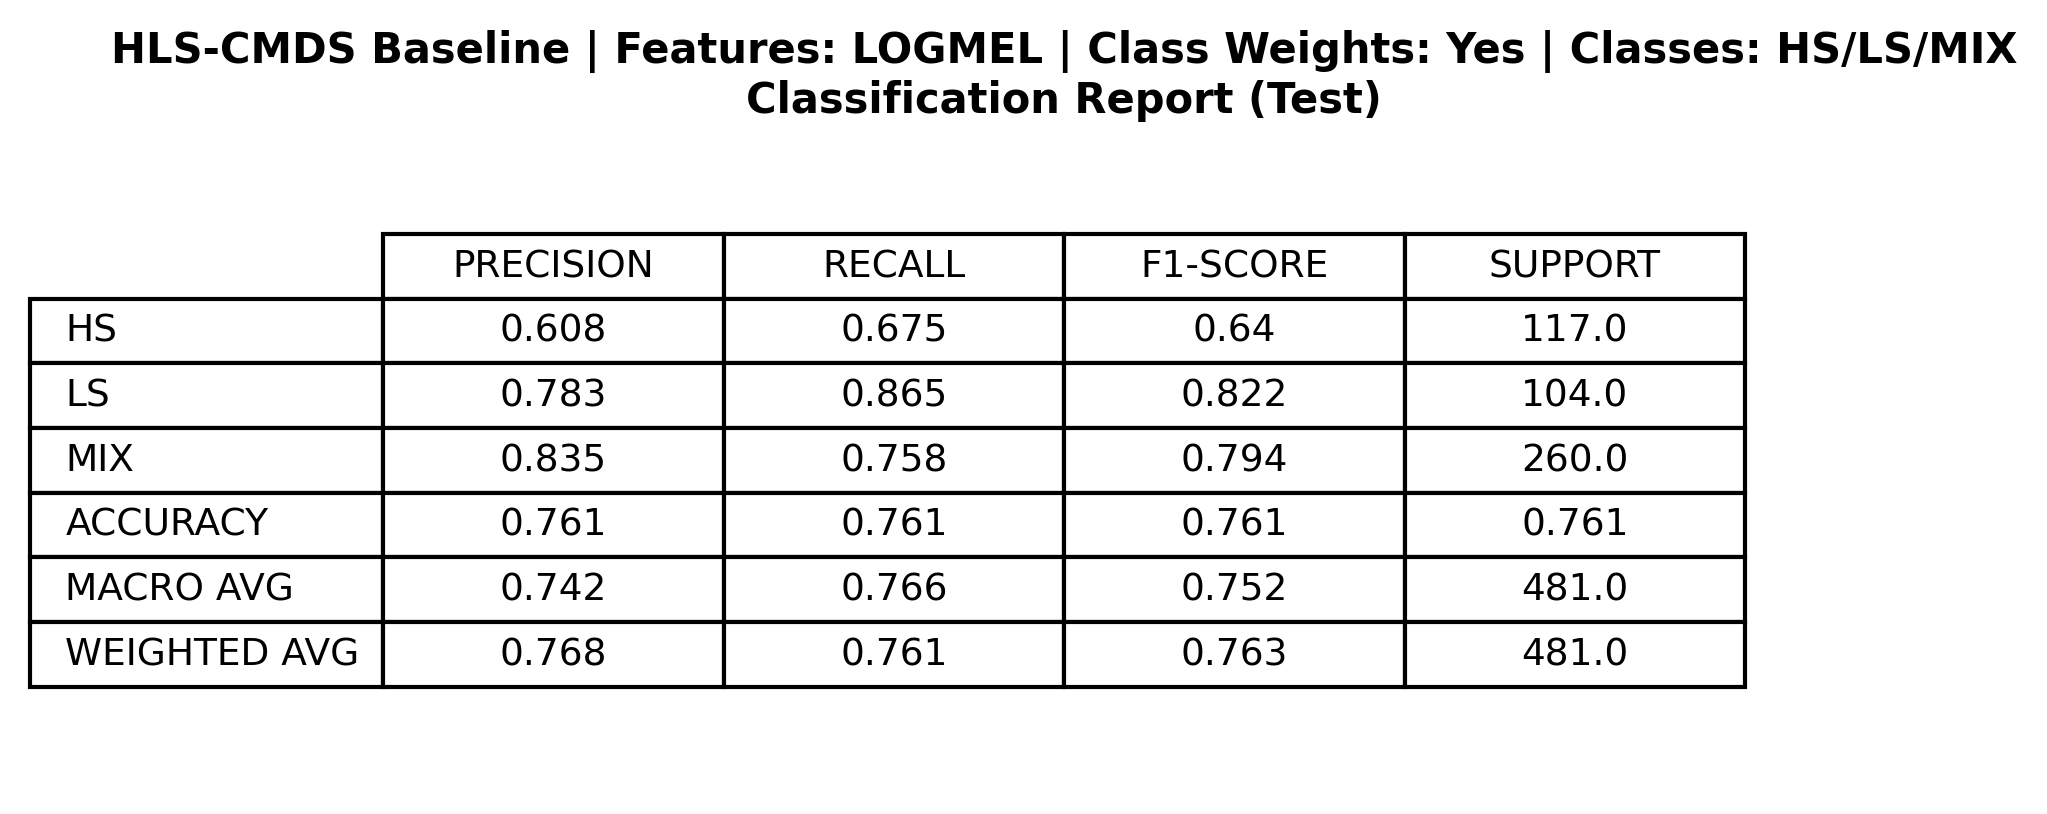

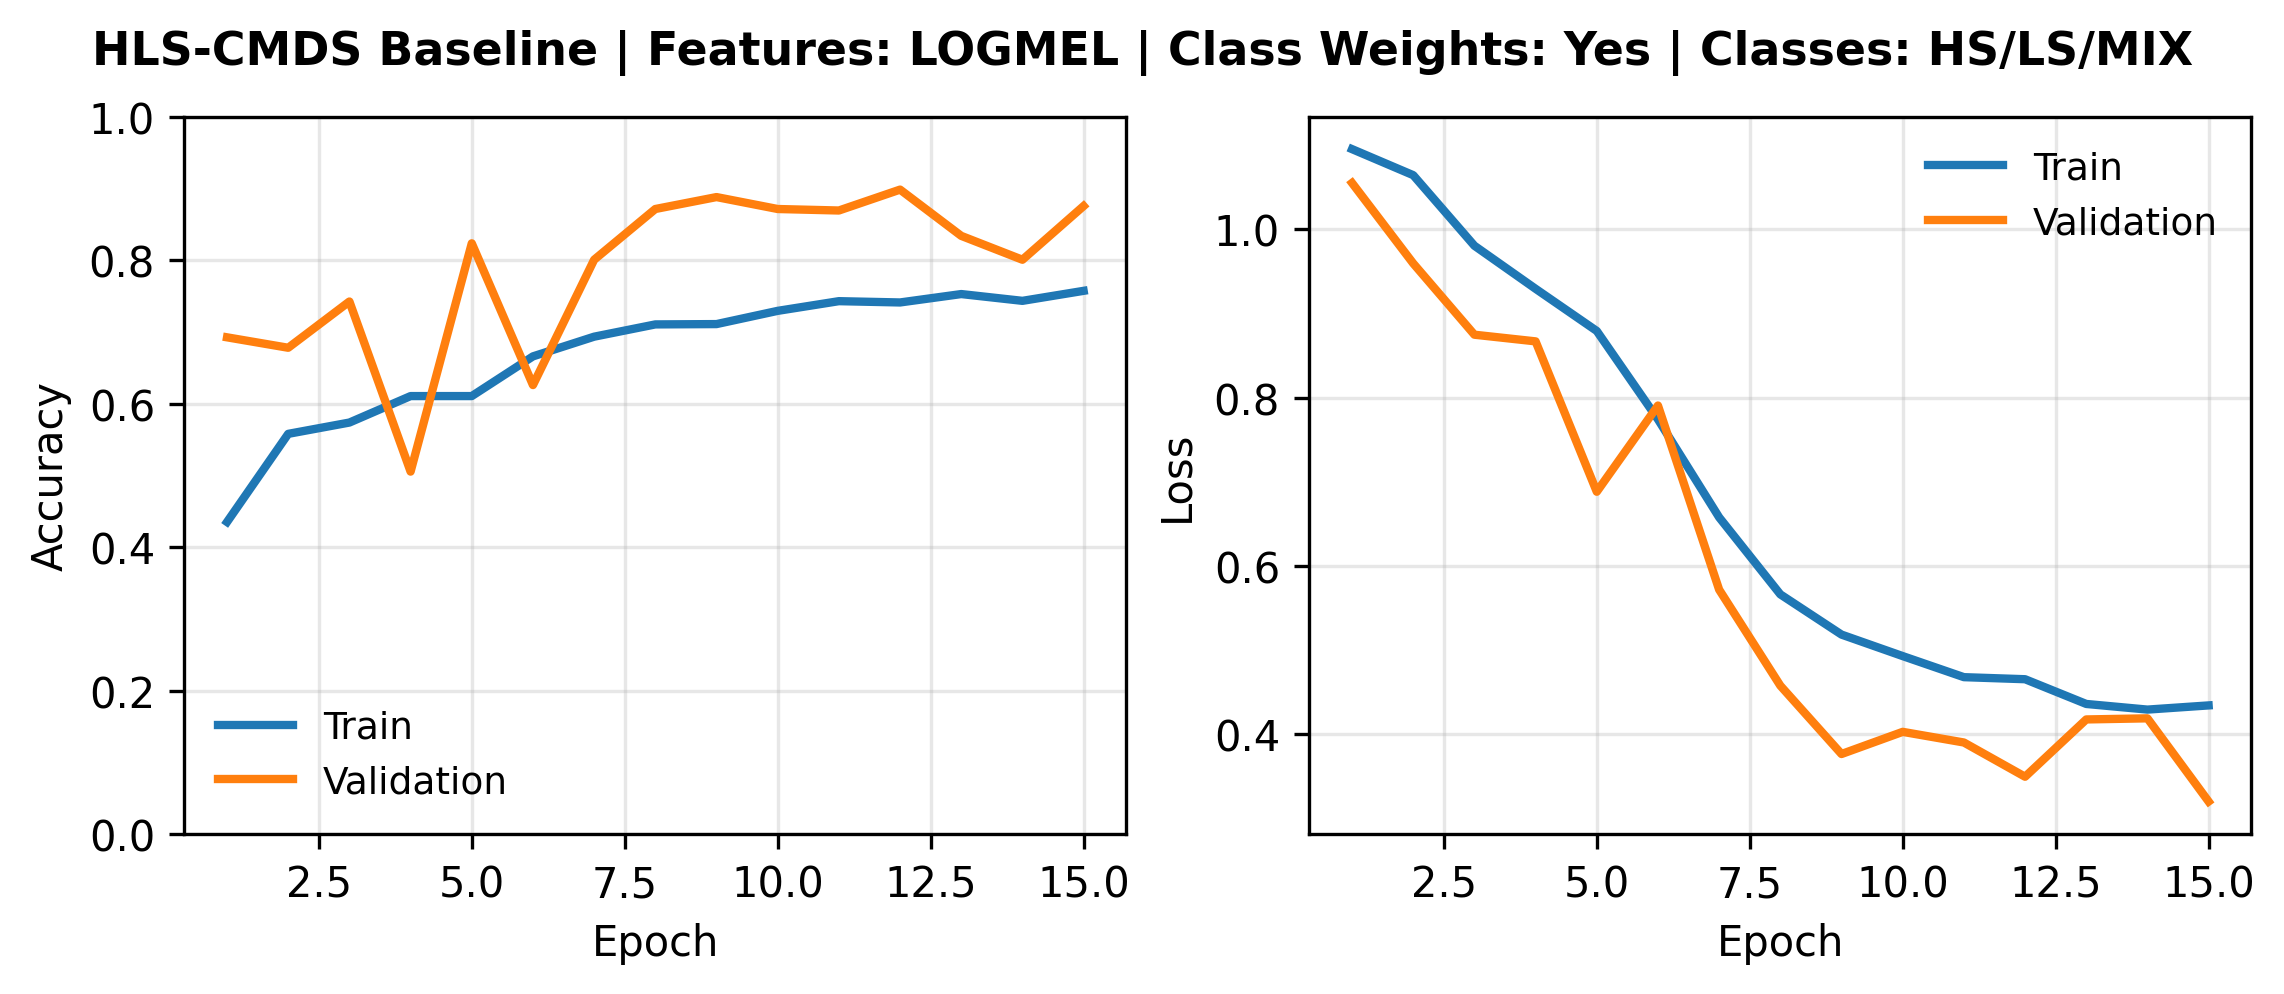

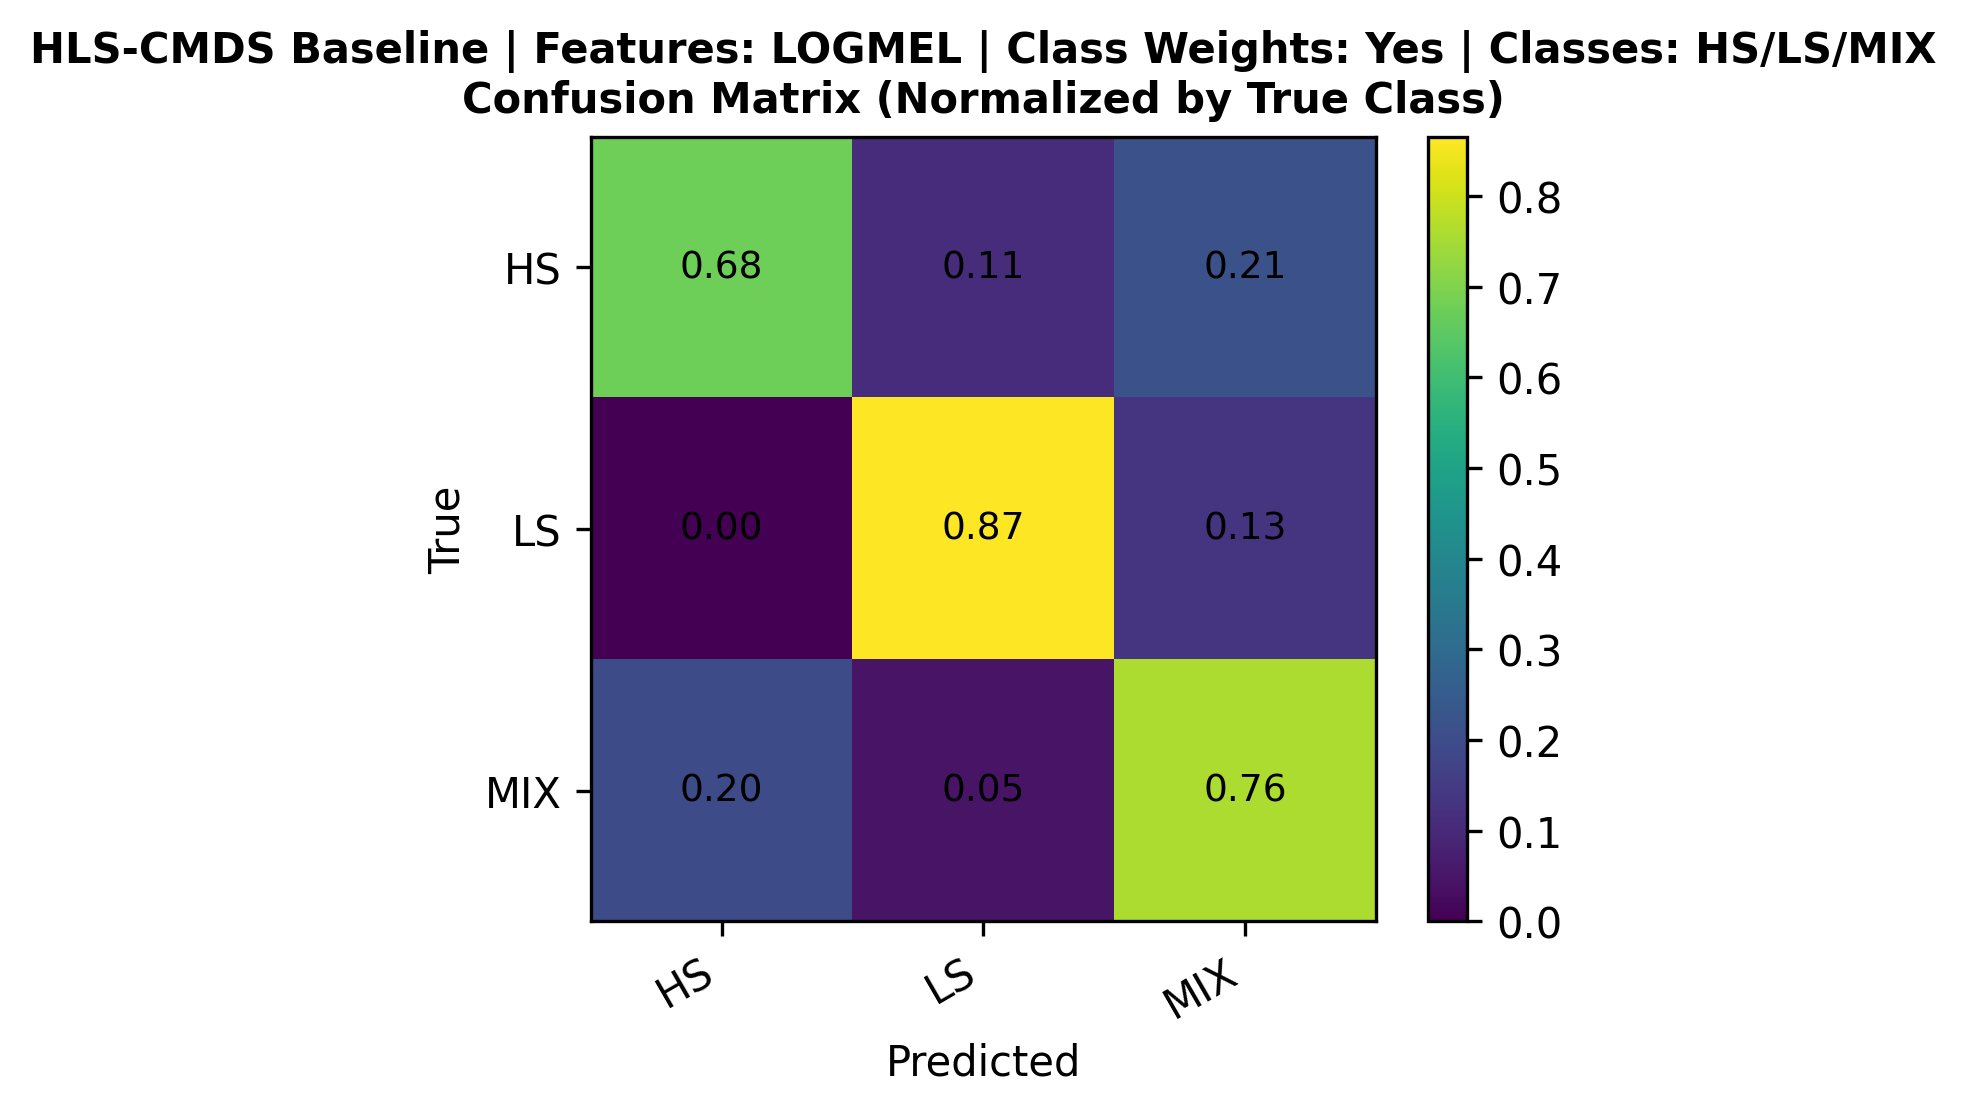

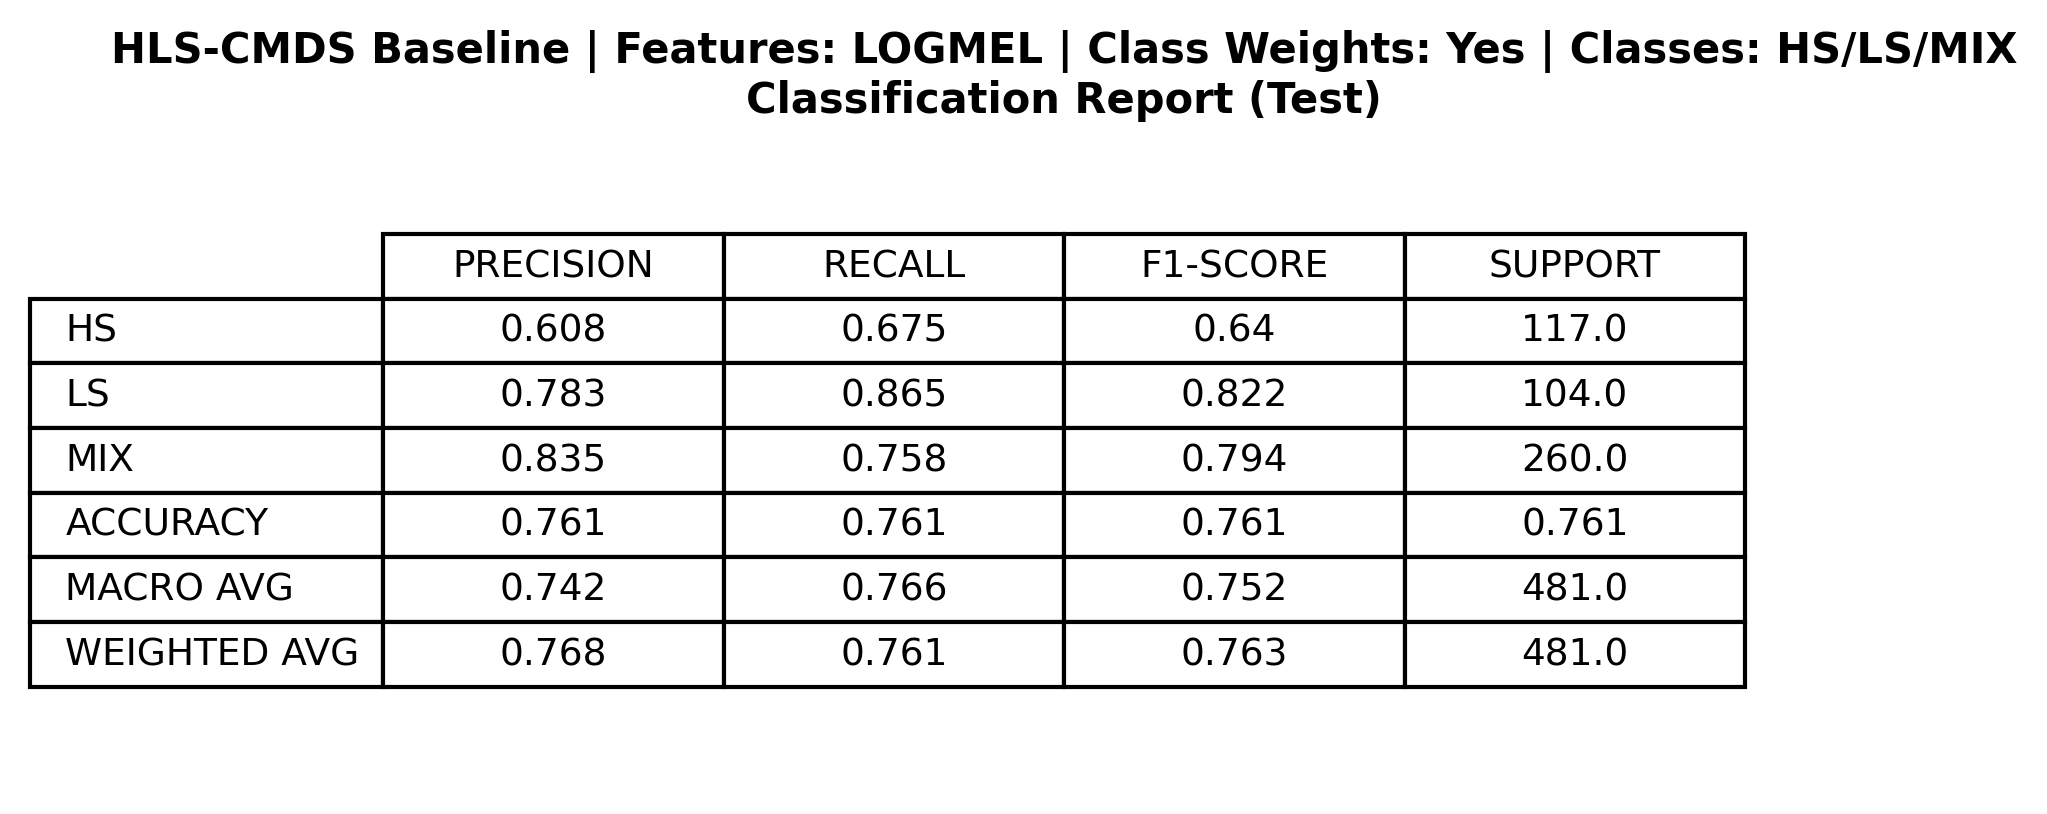

In [16]:
def parse_exp_name(exp_dir: Path) -> str:
    name = Path(exp_dir).name
    parts = name.split("__")
    feat = parts[0].upper()
    w = "Unknown"
    for p in parts[1:]:
        if p.startswith("weights_"):
            w = "Yes" if p.split("_")[-1] == "1" else "No"
    return f"HLS-CMDS Baseline | Features: {feat} | Class Weights: {w} | Classes: HS/LS/MIX"

def plot_curves(exp_dir: str, dpi=300):
    exp_dir = Path(exp_dir)
    title = parse_exp_name(exp_dir)
    hist = pd.read_csv(exp_dir / "history.csv")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5, 3.2), dpi=dpi, constrained_layout=True)
    fig.suptitle(title, fontsize=11, fontweight="bold")

    ax1.plot(hist["epoch"], hist["train_acc"], label="Train", linewidth=2)
    ax1.plot(hist["epoch"], hist["val_acc"], label="Validation", linewidth=2)
    ax1.set_xlabel("Epoch"); ax1.set_ylabel("Accuracy"); ax1.set_ylim(0, 1.0)
    ax1.grid(True, alpha=0.3); ax1.legend(frameon=False, fontsize=9)

    ax2.plot(hist["epoch"], hist["train_loss"], label="Train", linewidth=2)
    ax2.plot(hist["epoch"], hist["val_loss"], label="Validation", linewidth=2)
    ax2.set_xlabel("Epoch"); ax2.set_ylabel("Loss")
    ax2.grid(True, alpha=0.3); ax2.legend(frameon=False, fontsize=9)

    fig.savefig(exp_dir / "plot_curves_acc_loss.png", bbox_inches="tight")
    return fig

def plot_cm(exp_dir: str, normalize="true", dpi=300):
    exp_dir = Path(exp_dir)
    title = parse_exp_name(exp_dir)
    cm = np.load(exp_dir / "confusion_matrix.npy").astype(float)

    if normalize == "true":
        denom = cm.sum(axis=1, keepdims=True)
        cmn = np.divide(cm, denom, out=np.zeros_like(cm), where=denom != 0)
        fmt = ".2f"
        sub = "Confusion Matrix (Normalized by True Class)"
    else:
        cmn = cm
        fmt = ".0f"
        sub = "Confusion Matrix (Counts)"

    fig, ax = plt.subplots(figsize=(4.2, 3.6), dpi=dpi, constrained_layout=True)
    ax.set_title(f"{title}\n{sub}", fontsize=10, fontweight="bold")

    im = ax.imshow(cmn)
    fig.colorbar(im, ax=ax, fraction=0.05)

    ax.set_xticks(range(len(LABELS))); ax.set_yticks(range(len(LABELS)))
    ax.set_xticklabels([l.upper() for l in LABELS], rotation=30, ha="right")
    ax.set_yticklabels([l.upper() for l in LABELS])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

    for i in range(len(LABELS)):
        for j in range(len(LABELS)):
            ax.text(j, i, format(cmn[i, j], fmt), ha="center", va="center", fontsize=9)

    fig.savefig(exp_dir / f"plot_confusion_matrix_{normalize}.png", bbox_inches="tight")
    return fig

def plot_report(exp_dir: str, dpi=300):
    exp_dir = Path(exp_dir)
    title = parse_exp_name(exp_dir)

    rep = pd.read_csv(exp_dir / "test_classification_report.csv", index_col=0)
    rep = rep[["precision", "recall", "f1-score", "support"]].copy()
    rep = rep.round(3)

    fig, ax = plt.subplots(figsize=(5.8, 2.6), dpi=dpi, constrained_layout=True)
    ax.set_title(f"{title}\nClassification Report (Test)", fontsize=10, fontweight="bold")
    ax.axis("off")

    table = ax.table(
        cellText=rep.values,
        rowLabels=[r.upper() for r in rep.index],
        colLabels=[c.upper() for c in rep.columns],
        loc="center",
        cellLoc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.2)

    fig.savefig(exp_dir / "plot_classification_report.png", bbox_inches="tight")
    return fig

plot_curves(run_dir)
plot_cm(run_dir, normalize="true")
plot_report(run_dir)


In [17]:
runs = []
for feat in ["logmel", "stft"]:
    for w in [False, True]:
        runs.append(train_one_run(feature_type=feat, use_weights=w, epochs=15))

runs


C:\Users\MSI\AppData\Local\Temp\ipykernel_175244\938343573.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=DEVI

['C:\\Users\\MSI\\Documents\\Persoonlijke Projecten\\AI-Onderzoeksvragen\\research_questions\\heart_and_lungsounds\\data\\processed\\hls_cmds\\baseline_runs\\logmel__weights_0',
 'C:\\Users\\MSI\\Documents\\Persoonlijke Projecten\\AI-Onderzoeksvragen\\research_questions\\heart_and_lungsounds\\data\\processed\\hls_cmds\\baseline_runs\\logmel__weights_1',
 'C:\\Users\\MSI\\Documents\\Persoonlijke Projecten\\AI-Onderzoeksvragen\\research_questions\\heart_and_lungsounds\\data\\processed\\hls_cmds\\baseline_runs\\stft__weights_0',
 'C:\\Users\\MSI\\Documents\\Persoonlijke Projecten\\AI-Onderzoeksvragen\\research_questions\\heart_and_lungsounds\\data\\processed\\hls_cmds\\baseline_runs\\stft__weights_1']

In [18]:
summary = []
for d in runs:
    rep = pd.read_csv(Path(d) / "test_classification_report.csv", index_col=0)
    macro_f1 = float(rep.loc["macro avg", "f1-score"])
    summary.append({"run": Path(d).name, "macro_f1": macro_f1})

summary_df = pd.DataFrame(summary).sort_values("macro_f1", ascending=False).reset_index(drop=True)
summary_df


,run,macro_f1
0,logmel__weights_1,0.715479
1,stft__weights_1,0.665546
2,logmel__weights_0,0.660937
3,stft__weights_0,0.413786
